# Import the necessary libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.pyplot import figure, show
from matplotlib.ticker import MaxNLocator
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.models import Model, Sequential
from keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding, Bidirectional
from keras.optimizers import RMSprop
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping
from keras import optimizers
from pandas import Series
%matplotlib inline

Using TensorFlow backend.


### Load the data into Pandas dataframe

In [2]:
file = 'clickbait.csv'
with open(file, encoding="utf-8") as f_in:
    lines = [line.rstrip() for line in f_in]
    ybait = list([line for line in lines if line])

df_ycb = pd.DataFrame(ybait, columns=['judul'])
df_ycb['label'] = 'clickbait'

file = 'non_clickbait.csv'
with open(file, encoding="utf-8") as f_in:
    lines = [line.rstrip() for line in f_in]
    nbait = list([line for line in lines if line])

df_ncb = pd.DataFrame(nbait, columns=['judul'])
df_ncb['label'] = 'non_clickbait'

df = df_ycb.append(df_ncb, ignore_index=True).reset_index(drop=True)

In [3]:
df

,judul,label
0,"""Dihantam Ombak, Kapal Tenggelam di Danau Toba...",clickbait
1,Kuasa Hukum : Dosen USU Tidak Tulis Status ten...,clickbait
2,"""MANTAP!!! Tayang Hari Perdana, Jumlah Penonto...",clickbait
3,SEDIHNYA... Kak Seto Menangis Dua Kali Gara-ga...,clickbait
4,"""Undangan Buat Warga Medan, Acara Launching Fi...",clickbait
...,...,...
18330,Jumatan di Capitol Hill Difitnah,non_clickbait
18331,Capitol Hill Jadi Tempat Jumatan,non_clickbait
18332,Gaddafi Kecam Dewan Keamanan sebagai Dewan Teror,non_clickbait
18333,"""Ibnu al-Banna, Matematikus Legendaris dari Ma...",non_clickbait


In [4]:
# Hapus Data Duplikat
df = df.drop_duplicates()
df.duplicated().sum()


0

Understand the distribution better.

Text(0.5, 1.0, 'Jumlah data clicbait dan non-clickbait')

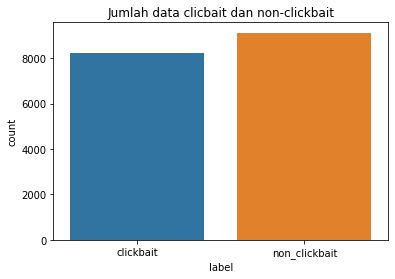

In [5]:
sns.countplot(df.label)
plt.xlabel('label')
plt.title('Jumlah data clicbait dan non-clickbait')

* Create input and output vectors.
* Process the labels.

In [6]:
# PREPROCESSING

internet_stop_words = ['antaranews',
    'antara','news','antaranews.com','tempo.co','tempointeraktif.com','republika',
    'online','ihram.co.id','republika.co.id','posmetro','medan','dream.co.id','hijab.dream.co.id',
    'travel.dream.co.id','parenting.dream.co.id','kepo.kapanlagi.com','plus.kapanlagi.com',
    'kapanlagi.com','sooperboy.com','brilio.net','otonomi.co.id','vemale.com',
    'otonomi','money.id','merdeka.com','feed.id','tribunwow.com'
    'tribunnews.com','tribun','tribunstyle.com','tribuntravel.com',
    'tribunnewsbogor.com','tribunjatim.com','grid.id','intisari.grid.id',
    'wartakota','tribunjakarta','gridoto.com','tribunsolo.com','superball.id',
    'tribunjateng''nakita.id','jogja.tribunnews.com','hemat.com','famous.id',
    'inspirasihijab.com','pergi.com','molto.co.id','muslimarket',
    'tribunnews.com ','braito.co.id', 'kapanlagi.com:'
]

indonesia_stop_words = [
    'yang', 'untuk', 'pada', 
    'ke', 'para', 'namun', 
    'menurut', 'antara', 'dia', 'dua', 'ia', 
    'seperti', 'jika', 'jika', 'sehingga', 'kembali', 
    'dan', 'tidak', 'ini', 'karena', 'kepada', 'oleh', 
    'saat', 'harus', 'sementara', 'setelah', 'belum', 
    'kami', 'sekitar', 'bagi', 'serta', 'di', 'dari', 
    'telah', 'sebagai', 'masih', 'hal', 'ketika', 
    'adalah', 'itu', 'dalam', 'bisa', 'bahwa', 'atau', 
    'hanya', 'kita', 'dengan', 'akan', 'juga', 'ada', 
    'mereka', 'sudah', 'saya', 'terhadap', 'secara', 
    'agar', 'lain', 'anda', 'begitu', 'mengapa', 
    'kenapa', 'yaitu', 'yakni', 'daripada', 'itulah', 
    'lagi', 'maka', 'tentang', 'demi', 'dimana', 
    'kemana', 'pula', 'sambil', 'sebelum', 'sesudah', 
    'supaya', 'guna', 'kah', 'pun', 'sampai', 'sedangkan',
    'selagi', 'sementara', 'tetapi', 'apakah', 'kecuali', 
    'sebab', 'selain', 'seolah', 'seraya', 'seterusnya', 
    'tanpa', 'agak', 'boleh', 'dapat', 'dsb', 'dst', 'dll', 
    'dahulu', 'dulunya', 'anu', 'demikian', 'tapi', 'ingin',
    'juga', 'nggak', 'mari', 'nanti', 'melainkan', 'oh', 'ok', 
    'seharusnya', 'sebetulnya', 'setiap', 'setidaknya', 'sesuatu', 
    'pasti', 'saja','toh', 'ya', 'walau', 'tolong', 'tentu',
    'amat', 'apalagi', 'bagaimanapun'
]



def remove_internet_stopwords(x):
    return ' '.join([word for word in str(x).lower().split() if word not in internet_stop_words])

def remove_indonesia_stopwords(x):
    return ' '.join([word for word in str(x).lower().split() if word not in indonesia_stop_words])



In [7]:
# lower
df['judul'].str.lower()

# Remove internet stop words
df.judul = df.judul.apply(remove_internet_stopwords)

# Remove Indonesia stop words
df.judul = df.judul.apply(remove_indonesia_stopwords)

# Remove tanda baca
df['judul'] = df['judul'].str.replace('[^\w\s]', ' ')


c:\users\asus\appdata\local\programs\python\python36\lib\site-packages\pandas\core\generic.py:5159: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
c:\users\asus\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


In [8]:
df

,judul,label
0,dihantam ombak kapal tenggelam danau toba p...,clickbait
1,kuasa hukum dosen usu tulis status bom,clickbait
2,mantap tayang hari perdana jumlah penonto...,clickbait
3,sedihnya kak seto menangis kali gara gara anak,clickbait
4,undangan buat warga medan acara launching fi...,clickbait
...,...,...
18330,jumatan capitol hill difitnah,non_clickbait
18331,capitol hill jadi tempat jumatan,non_clickbait
18332,gaddafi kecam dewan keamanan dewan teror,non_clickbait
18333,ibnu al banna matematikus legendaris maroko,non_clickbait


In [9]:
X = df.judul
Y = df.label
le = LabelEncoder()
Y = le.fit_transform(Y)
Y = Y.reshape(-1,1)

Split into training and test data.

In [10]:
X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size=0.2)

In [12]:
X_test

11327                         gempa aceh telan korban jiwa
9897              asus pastikan bawa zenfone 5 indonesia  
450               sabu malaysia dipasok melalui jalur laut
3509          benarkah beras menyelamatkan ponsel basah   
4297      david beckham blusukan kampung semarang temui...
                               ...                        
16752     zainuddin mz  sejak kecil bakat dakwahnya ter...
796               tanggapan suami arzetti kasus istrinya  
17641    akun facebook lomba karikatur nabi muhammad di...
9029     portugal ubah tiga susunan pemain lawan uruguay  
3487          video ungkapan hati korban asap tebal riau  
Name: judul, Length: 3470, dtype: object

### Process the data
* Tokenize the data and convert the text to sequences.
* Add padding to ensure that all the sequences have the same shape.
* There are many ways of taking the *max_len* and here an arbitrary length of 150 is chosen.

In [13]:
max_words = 1000
max_len = 150
tok = Tokenizer(num_words=max_words)
tok.fit_on_texts(X_train)
sequences = tok.texts_to_sequences(X_train)
sequences_matrix = sequence.pad_sequences(sequences,maxlen=max_len)

In [14]:
sequences_matrix[1]

array([  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0, 192,  70,  87])

### RNN
Define the RNN structure.

In [15]:
def RNN():
    inputs = Input(name='inputs',shape=[max_len])
    layer = Embedding(max_words,50,input_length=max_len)(inputs)
    layer = LSTM(64)(layer)
    #layer = Dense(256,name='FC1')(layer)
    layer = Activation('relu')(layer)
    layer = Dropout(0.5)(layer)
    layer = Dense(1,name='out_layer')(layer)
    layer = Activation('sigmoid')(layer)
    model = Model(inputs=inputs,outputs=layer)
    return model
# def RNN():
    
#     # Input Layer
#     inputs = Input(name='inputs',shape=[max_len])
    
    
#     # Embedding layer
#     # Argumen (a vector space of 50 dimensions)
#     # Memiliki jumlah vocab = 1000 kata
#     # Output 150 vector dengan masing2 berdimensi 50
    
#     layer = Embedding(max_words,50,input_length=max_len)(inputs)
    
#     # LSTM Layer dengan 64 memory unit (smart neuron)
#     layer = LSTM(64)(layer)
#     #layer = LSTM(64, dropout=0.2, recurrent_dropout=0.2)(layer)

#     # Output Layer
#     # Dense Layer 1 neuron untuk membuat keputusan 0 atau 1 (binary classification)
#     layer = Dense(1,name='out_layer')(layer)
#     layer = Activation('sigmoid')(layer)
    
#     model = Model(inputs=inputs,outputs=layer)
#     return model

Call the function and compile the model.

In [16]:
model = RNN()
model.summary()
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          (None, 150)               0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 150, 50)           50000     
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                29440     
_________________________________________________________________
activation_1 (Activation)    (None, 64)                0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
out_layer (Dense)            (None, 1)                 65        
_________________________________________________________________
activation_2 (Activation)    (None, 1)                 0   

Fit on the training data.

In [17]:
history = model.fit(sequences_matrix,Y_train,batch_size=128,epochs=10,
          validation_split=0.2)

# , callbacks=[EarlyStopping(monitor='val_loss',min_delta=0.0001)]
# 

c:\users\asus\appdata\local\programs\python\python36\lib\site-packages\tensorflow\python\framework\indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 11104 samples, validate on 2776 samples
Epoch 1/10
11104/11104 [==============================] - 15s 1ms/step - loss: 0.6116 - accuracy: 0.6852 - val_loss: 0.4682 - val_accuracy: 0.7911
Epoch 2/10
11104/11104 [==============================] - 13s 1ms/step - loss: 0.4137 - accuracy: 0.8144 - val_loss: 0.3755 - val_accuracy: 0.8267
Epoch 3/10
11104/11104 [==============================] - 13s 1ms/step - loss: 0.3554 - accuracy: 0.8435 - val_loss: 0.3670 - val_accuracy: 0.8278
Epoch 4/10
11104/11104 [==============================] - 14s 1ms/step - loss: 0.3347 - accuracy: 0.8517 - val_loss: 0.3681 - val_accuracy: 0.8242
Epoch 5/10
11104/11104 [==============================] - 14s 1ms/step - loss: 0.3263 - accuracy: 0.8565 - val_loss: 0.3660 - val_accuracy: 0.8285
Epoch 6/10
11104/11104 [==============================] - 15s 1ms/step - loss: 0.3191 - accuracy: 0.8584 - val_loss: 0.3697 - val_accuracy: 0.8231
Epoch 7/10
11104/11104 [==============================] - 14s 1ms/ste

In [18]:
def plot_model_history(history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    figx = plt.figure()
    # summarize history for accuracy
   
    axs[0].plot(range(1,len(history.history['accuracy'])+1),np.array(history.history['accuracy'])*100,'r',linewidth=3.0)
    axs[0].plot(range(1,len(history.history['val_accuracy'])+1),np.array(history.history['val_accuracy'])*100,'b',linewidth=3.0)
    axs[0].set_title('Accuracy Curve', fontsize = 16)
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(history.history['accuracy'])+1),len(history.history['accuracy'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1,len(history.history['loss'])+1),np.array(history.history['loss'])*100,'r',linewidth=3.0)
    axs[1].plot(range(1,len(history.history['val_loss'])+1),np.array(history.history['val_loss'])*100, 'b',linewidth=3.0)
    axs[1].set_title('Loss Curve', fontsize = 16)
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(history.history['loss'])+1),len(history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    #figx.savefig('first_fix.png')
    plt.show()

c:\users\asus\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:11: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  # This is added back by InteractiveShellApp.init_path()
c:\users\asus\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:19: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.


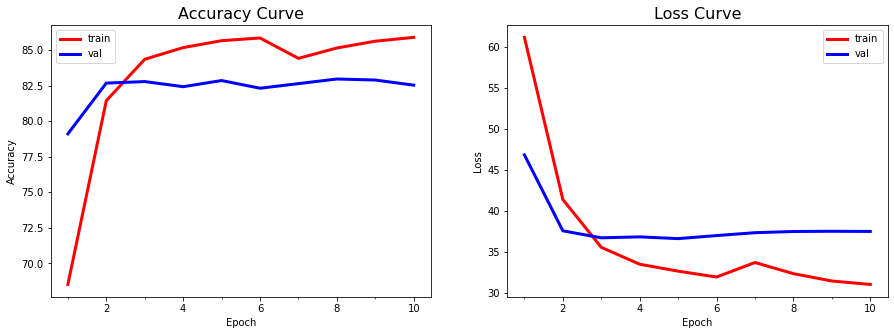

<Figure size 432x288 with 0 Axes>

In [19]:
plot_model_history(history)

c:\users\asus\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  # This is added back by InteractiveShellApp.init_path()


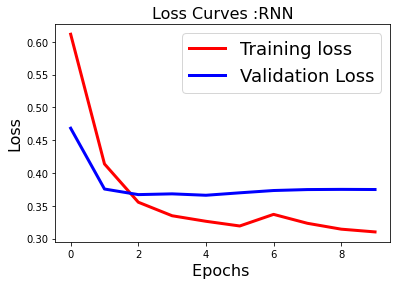

In [20]:
plt.switch_backend('agg')

fig1 = plt.figure()
plt.plot(history.history['loss'],'r',linewidth=3.0)
plt.plot(history.history['val_loss'],'b',linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves :RNN',fontsize=16)
#fig1.savefig('loss_rnn1.png')
plt.show()

# from matplotlib import pyplot
# pyplot.plot(history.history['loss'])
# pyplot.plot(history.history['val_loss'])
# pyplot.title('model train vs validation loss')
# pyplot.ylabel('loss')
# pyplot.xlabel('epoch')
# pyplot.legend(['train', 'validation'], loc='upper left')
# pyplot.show()

c:\users\asus\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  # This is added back by InteractiveShellApp.init_path()


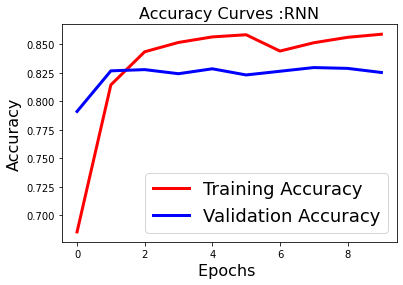

In [21]:
plt.switch_backend('agg')

fig1 = plt.figure()
plt.plot(history.history['accuracy'],'r',linewidth=3.0)
plt.plot(history.history['val_accuracy'],'b',linewidth=3.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves :RNN',fontsize=16)
#fig1.savefig('acc_rnn1.png')
plt.show()

# from matplotlib import pyplot
# pyplot.plot(history.history['acc'])
# pyplot.plot(history.history['val_acc'])
# pyplot.title('model train vs validation acc')
# pyplot.ylabel('acc')
# pyplot.xlabel('epoch')
# pyplot.legend(['train', 'validation'], loc='upper left')
# pyplot.show()

The model performs well on the validation set and this configuration is chosen as the final model.

Process the test set data.

In [22]:
X_test

11327                         gempa aceh telan korban jiwa
9897              asus pastikan bawa zenfone 5 indonesia  
450               sabu malaysia dipasok melalui jalur laut
3509          benarkah beras menyelamatkan ponsel basah   
4297      david beckham blusukan kampung semarang temui...
                               ...                        
16752     zainuddin mz  sejak kecil bakat dakwahnya ter...
796               tanggapan suami arzetti kasus istrinya  
17641    akun facebook lomba karikatur nabi muhammad di...
9029     portugal ubah tiga susunan pemain lawan uruguay  
3487          video ungkapan hati korban asap tebal riau  
Name: judul, Length: 3470, dtype: object

In [23]:
test_sequences = tok.texts_to_sequences(X_test)
test_sequences_matrix = sequence.pad_sequences(test_sequences,maxlen=max_len)

Evaluate the model on the test set.

In [24]:
accr = model.evaluate(test_sequences_matrix,Y_test)

3470/3470 [==============================] - 2s 513us/step


In [25]:
predik = model.predict(test_sequences_matrix)
predik[0:]

array([[0.8322987 ],
       [0.6947391 ],
       [0.8917352 ],
       ...,
       [0.89456815],
       [0.6550242 ],
       [0.10899132]], dtype=float32)

In [26]:
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

Test set
  Loss: 0.380
  Accuracy: 0.822


In [27]:
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
    model.save_weights('clickbait_lstm_model.h5')

In [28]:
from keras.models import model_from_json
#load json file
json_file = open("model.json", "r")
loaded_model_json = json_file.read()
json_file.close()

#load weight
model = model_from_json(loaded_model_json)
model.load_weights("clickbait_lstm_model.h5")

In [29]:
file = pd.read_csv('judul_24.csv')
file_series = file.T.squeeze()
file_x = tok.texts_to_sequences(file_series)
file_sequences_matrix = sequence.pad_sequences(file_x,maxlen=max_len)

file_sequences_matrix

array([[  0,   0,   0, ...,   0,  90, 552],
       [  0,   0,   0, ...,  36, 903,  18],
       [  0,   0,   0, ..., 901, 280, 191],
       ...,
       [  0,   0,   0, ..., 494, 437, 633],
       [  0,   0,   0, ..., 494, 767, 136],
       [  0,   0,   0, ..., 110,  37, 260]])

In [30]:
prediksi = model.predict(file_sequences_matrix)
prediksi = np.around(prediksi)
prediksi = prediksi.astype(str)
x=0
for i in prediksi:
    if (float(i)) ==0.0:
        np.put(prediksi[x],0,'clickbait')
    else:
        np.put(prediksi[x],0,'non-clickbait')
    
    x+=1
param = file.values
final = np.hstack((param,prediksi))
final

array([['JPU Simalungun Permainkan Pasal Dakwaan, Bakal Dilapor ke Kajati',
        'clickbait'],
       ['Terciduk Usai Beraksi, 2 Begal Diamankan Polisi', 'clickbait'],
       ['Kategori PAAR, Desa Marendal II Nominasi Terbaik Tingkat Nasional',
        'non-clickbait'],
       ['Polisi Ringkus Terduga Pembunuh Sadis di Kebun Sawit Namorube',
        'clickbait'],
       ['Hari Veteran Nasional Diperingati di Gedung Yudha Bhakti LVRI Deliserdang',
        'non-clickbait'],
       ['Minta Uang Tak Dikasih, Pemuda Ini Pukuli Ayah Angkatnya',
        'clickbait'],
       ['Tabrak Mobil Double Cabin, Pemuda Simalungun Tewas Mengenaskan',
        'clickbait'],
       ['2 Lagi Korban Hanyut di Pemandian Bedeng Sungai Asahan Ditemukan',
        'clickbait'],
       ['Pengedar Sabu di Gang Jati, Dibekuk Tim Pegasus Polsek Medan Area',
        'clickbait'],
       ['Sekwan DPRD Deliserdang Layani Warga di Warung Dhuafa PDPM',
        'clickbait'],
       ['Kerjasama dengan Dinsos, Anggota DPR